In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from common_variables import *
from time_series import *

In [22]:
#将所有的数据训练两百次
epochs = 200
np.random.seed(seed)
tf.random.set_random_seed(seed)

In [23]:
df = pd.read_csv(train_time_series_path, dayfirst=True, 
    index_col=['Date_Time'], parse_dates=['Date_Time'])
df

,Unnamed: 0,HLAvg,MA,Returns
Date_Time,,,,
2001-01-01,64,114.460,114.508929,-0.000062
2001-01-01,66,114.495,114.505714,-0.000028
2001-01-01,68,114.435,114.494643,-0.000097
2001-01-01,70,114.430,114.482500,-0.000106
2001-01-01,72,114.395,114.478571,-0.000034
...,...,...,...,...
2001-01-01,1027830,124.075,124.060000,0.000003
2001-01-01,1027832,124.040,124.058929,-0.000009
2001-01-01,1027834,124.045,124.057500,-0.000012


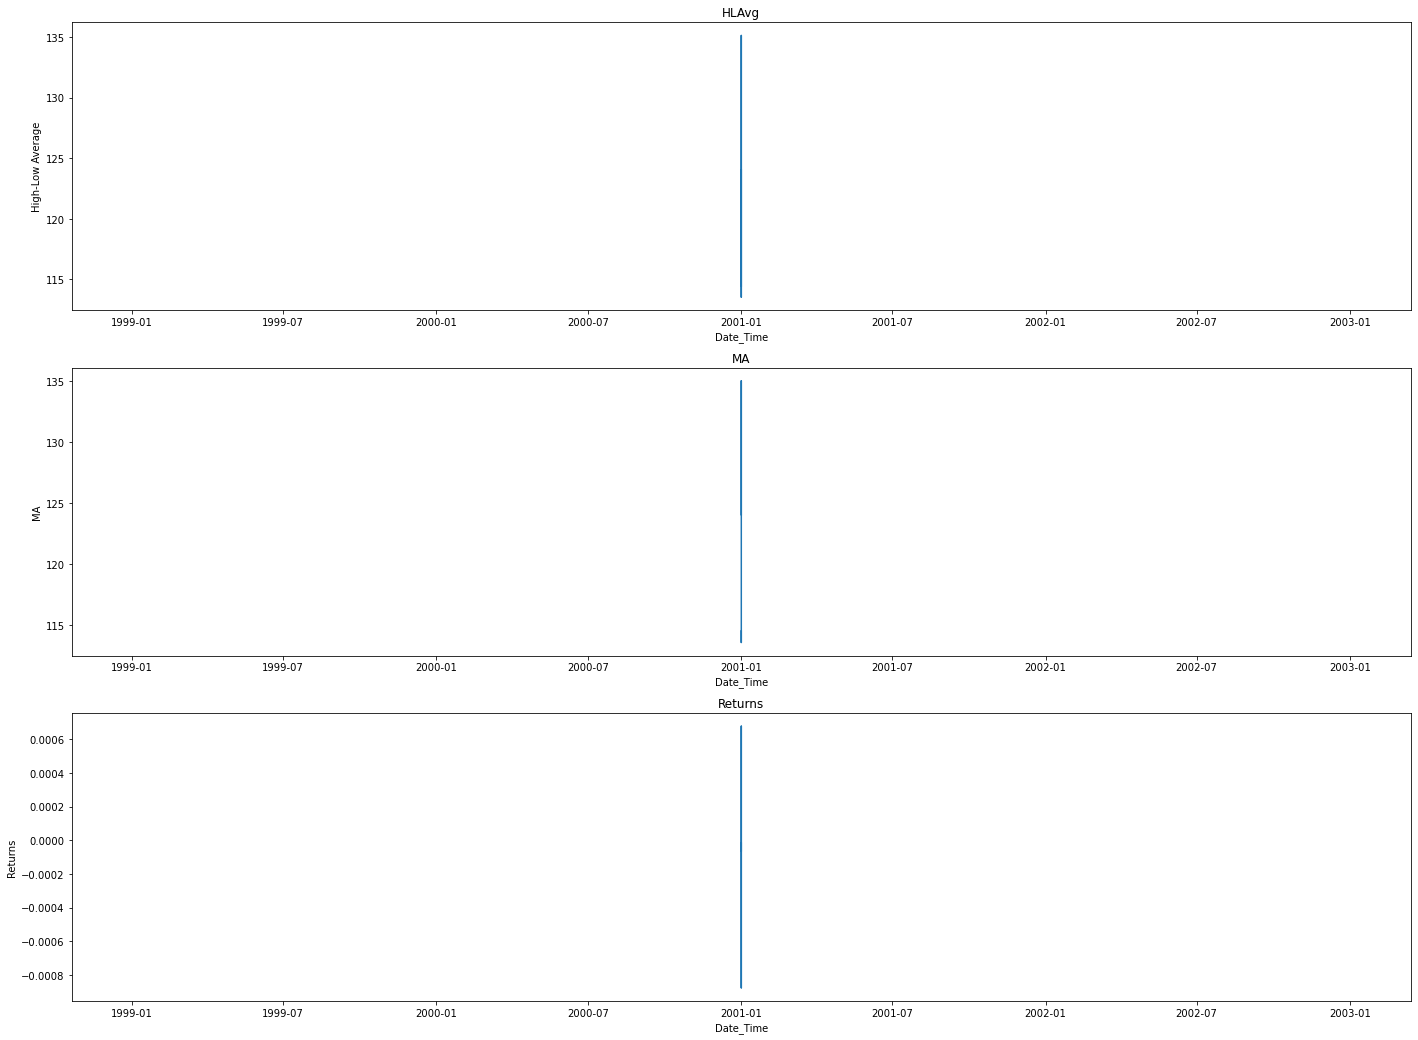

In [24]:
fig = plt.figure(figsize=(24, 18))
ax1, ax2, ax3 = fig.subplots(3)
ax1.set_title('HLAvg')
ax1.set(xlabel='Date_Time', ylabel='High-Low Average')
ax1.plot(df['HLAvg'])
ax2.set_title('MA')
ax2.set(xlabel='Date_Time', ylabel='MA')
ax2.plot(df['MA'])
ax3.set_title('Returns')
ax3.set(xlabel='Date_Time', ylabel='Returns')
ax3.plot(df['Returns'])

In [25]:
scaler = MinMaxScaler()
train_values = scaler.fit_transform(df[['Returns']].values)

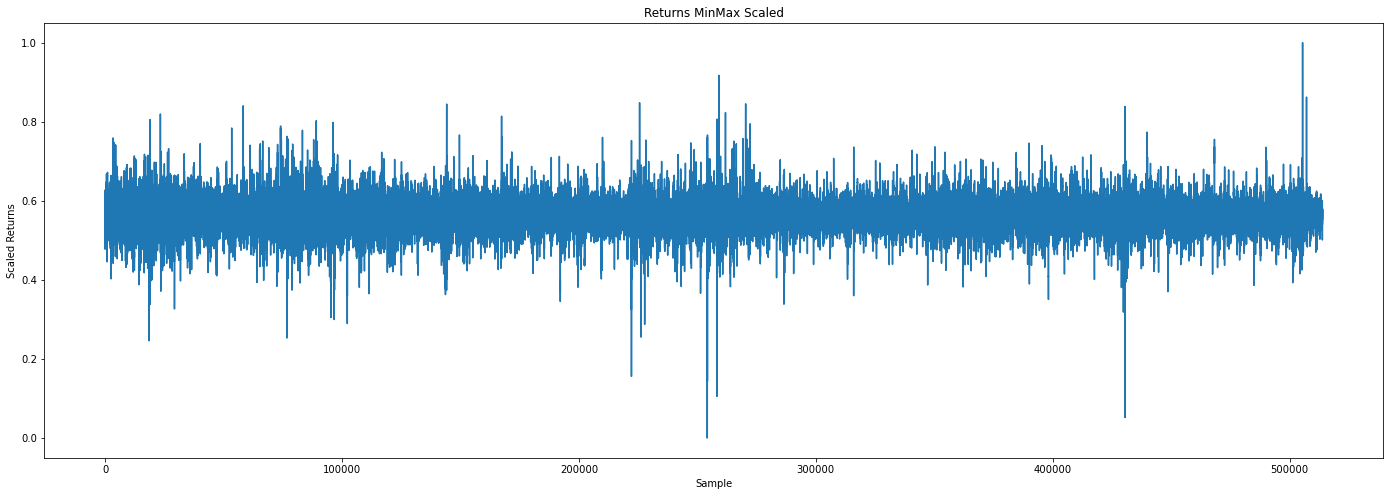

In [26]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.subplots(1)
ax1.set_title('Returns MinMax Scaled')
ax1.set(xlabel='Sample', ylabel='Scaled Returns')
ax1.plot(train_values)

In [27]:
X, y = get_train(train_values, window_size)

X (513632, 256, 1), y (513632, 1)


In [28]:
df_val = pd.read_csv(validate_time_series_path, dayfirst = True, usecols=['Date_Time','Returns'],
    index_col=['Date_Time'], parse_dates=['Date_Time'])
df_val['Scaled'] = scaler.transform(df_val[['Returns']].values)
X_val, y_val = get_val(df_val['Scaled'].values, window_size)

X (5184, 256, 1), y (5184,)


In [29]:
model = Sequential()
model.add(LSTM(76, input_shape=(X.shape[1], 1), return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss="mse", optimizer=optimizer)

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 76)                23712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 77        
Total params: 23,789
Trainable params: 23,789
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X, y, validation_data=(X_val, y_val), epochs = epochs, batch_size = batch_size, shuffle=False, verbose = 2)

Train on 513632 samples, validate on 5184 samples
Epoch 1/200
513632/513632 - 2393s - loss: 4.7302e-04 - val_loss: 1.4718e-04
Epoch 2/200
513632/513632 - 2399s - loss: 1.2116e-04 - val_loss: 1.2512e-04
Epoch 3/200
513632/513632 - 2361s - loss: 1.1323e-04 - val_loss: 1.1593e-04
Epoch 4/200
513632/513632 - 2348s - loss: 1.0474e-04 - val_loss: 1.2498e-04
Epoch 5/200
513632/513632 - 2345s - loss: 9.9780e-05 - val_loss: 1.0739e-04
Epoch 6/200
513632/513632 - 2359s - loss: 9.1247e-05 - val_loss: 9.7507e-05
Epoch 7/200
513632/513632 - 2362s - loss: 8.9902e-05 - val_loss: 1.0789e-04
Epoch 8/200
513632/513632 - 2358s - loss: 8.4465e-05 - val_loss: 9.2054e-05
Epoch 9/200
513632/513632 - 2336s - loss: 8.0819e-05 - val_loss: 8.6216e-05
Epoch 10/200
513632/513632 - 2334s - loss: 7.8763e-05 - val_loss: 8.8328e-05
Epoch 11/200
513632/513632 - 2335s - loss: 7.8132e-05 - val_loss: 8.6744e-05
Epoch 12/200
513632/513632 - 2324s - loss: 7.8661e-05 - val_loss: 9.2375e-05
Epoch 13/200
513632/513632 - 2323s 

In [ ]:
save_model(model, model_path)
joblib.dump(scaler, scaler_path) 
print("hello,world")

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][7:], label='Train Loss')
ax1.plot(history.history['val_loss'][7:], label='Val Loss')
ax1.legend()